In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

In [3]:
MNM_nb_folder = os.path.join('..', '..', '..', 'side_project', 'network_builder')
sys.path.append(MNM_nb_folder)
python_lib_folder = os.path.join('..', '..', 'pylib')
sys.path.append(python_lib_folder)

In [4]:
from MNM_nb import *
import MNMAPI
from sDODE import *

In [5]:
data_folder = os.path.join('..', '..', '..', 'data', 'input_files_33net')

In [6]:
nb = MNM_network_builder()
nb.load_from_folder(data_folder)
O_dist = np.arange(3)
D_dist = np.arange(3)
usefuk_link_list = list(filter(lambda x: x.typ == 'CTM', nb.link_list))

MNM_config
MNM_pathtable


In [7]:
len(usefuk_link_list)

24

In [8]:
num_observed_links = 18

In [9]:
config = dict()

config['use_link_flow'] = True
config['use_link_tt'] = False
config['link_flow_weight'] = 1
config['link_tt_weight'] = 1
config['num_data'] = 10
config['observed_links'] = list(map(lambda x: x.ID, np.random.choice(usefuk_link_list, num_observed_links)))
config['paths_list'] = list(range(nb.config.config_dict['FIXED']['num_path']))

In [10]:
num_interval = nb.config.config_dict['DTA']['max_interval']
theta = 0.01

In [11]:
sdode = SDODE(nb, config)
# true_q = sdode.init_demand_flow(init_scale = 50)
true_q_para = OD_parameter_server(sdode.demand_list, sdode.num_assign_interval)
true_q_para.construct(O_dist, D_dist)
true_q_para.initialize(mean_scale = 100, std_scale= 10, 
                        O_cov_scale = 5, D_cov_scale = 5)
true_q = np.concatenate(true_q_para.demand_mean_list)
old_f = np.zeros(num_interval * len(config['paths_list']))
num_iters = 100
P = sdode.nb.get_route_portion_matrix()
true_f = P.dot(true_q)
for i in range(num_iters):
    dta = sdode._run_simulation(true_f)
    path_cost = dta.get_path_tt(np.arange(0, sdode.num_loading_interval, sdode.ass_freq))
    sdode.assign_route_portions(path_cost, theta = theta)
    new_f = sdode.nb.get_route_portion_matrix().dot(true_q)
    true_f = np.float(i) / np.float(i+1) * true_f + np.float(1) / np.float(i+1) * new_f
#     print np.linalg.norm(true_f - old_f)
    old_f = true_f
    sdode.nb.update_demand_path(new_f)

In [12]:
assert (np.isclose(true_q.sum(), true_f.sum()))

In [13]:
dta = sdode._run_simulation(true_f)
true_P = sdode.nb.get_route_portion_matrix()
true_full_dar = sdode.get_full_dar(dta, true_f)
true_dar = true_full_dar[sdode.get_full_observed_link_index(),:]
true_x = true_dar.dot(true_f)
true_path_cost = dta.get_path_tt(np.arange(0, sdode.num_loading_interval, sdode.ass_freq))

In [14]:
num_data = config['num_data']
data_dict = dict()
data_dict['link_flow'] = list()
sdode = SDODE(nb, config)
for i in range(config['num_data']):
    q_e, _ = true_q_para.forward()
    f_e = true_P.dot(q_e)
    dta = sdode._run_simulation(f_e)
    full_dar_e = sdode.get_full_dar(dta, f_e)
    dar_e = full_dar_e[sdode.get_full_observed_link_index(),:]
    x_e = dar_e.dot(f_e)
    link_df = pd.DataFrame(index = range(num_interval), columns = config['observed_links'], 
                           data = x_e.reshape((num_interval, len(config['observed_links']))) 
                               + np.random.randn(num_interval, len(config['observed_links'])) * 0.0)
    data_dict['link_flow'].append(link_df)

In [15]:
sdode.add_data(data_dict)

In [35]:
print "Start sovling"
q_para, loss_list1 = sdode.estimate_demand_cov(O_dist, D_dist, init_mean_scale = 1, 
                      init_std_scale = 0.1, init_O_cov_scale = 0.1,
                      init_D_cov_scale = 0.1, step_size = 1, theta = theta, max_epoch = 100,
                                  adagrad = True, known_path_cost = true_path_cost)

Start sovling
Epoch: 0 Loss: 696.197649618859
Epoch: 1 Loss: 633.1334877689294
Epoch: 2 Loss: 591.7481060617214
Epoch: 3 Loss: 542.2927678124782
Epoch: 4 Loss: 532.3493434629761
Epoch: 5 Loss: 495.8298299022932
Epoch: 6 Loss: 477.1167567199197
Epoch: 7 Loss: 453.37536011137564
Epoch: 8 Loss: 443.8990768824289
Epoch: 9 Loss: 437.57990860282945
Epoch: 10 Loss: 395.5014700273324
Epoch: 11 Loss: 390.7967780560429
Epoch: 12 Loss: 373.2028270695885
Epoch: 13 Loss: 362.08762320009794
Epoch: 14 Loss: 348.54197594714435
Epoch: 15 Loss: 346.53542562086113
Epoch: 16 Loss: 327.1058032314065
Epoch: 17 Loss: 319.19689236959505
Epoch: 18 Loss: 307.73114796108047
Epoch: 19 Loss: 311.0996159845828
Epoch: 20 Loss: 310.84922595143973
Epoch: 21 Loss: 287.166155027481
Epoch: 22 Loss: 279.9178775616917
Epoch: 23 Loss: 268.4549590484201
Epoch: 24 Loss: 279.1964002653981
Epoch: 25 Loss: 263.5921860925731
Epoch: 26 Loss: 255.16180806419396
Epoch: 27 Loss: 248.49851338017038
Epoch: 28 Loss: 258.50578455667477
E

In [36]:
q_ee = np.concatenate(q_para.demand_mean_list)
P_ee = sdode.nb.get_route_portion_matrix()
f_ee = P_ee.dot(q_ee)
dta = sdode._run_simulation(f_ee)
full_dar_ee = sdode.get_full_dar(dta, f_ee)
dar_ee = full_dar_ee[sdode.get_full_observed_link_index(),:]
x_ee = dar_ee.dot(f_ee)

In [18]:
print "Start sovling"
q_e, loss_list2 = sdode.estimate_demand(init_scale = 0.1, step_size = 1, 
                      max_epoch = 100, adagrad = False,
                      theta = theta)

Start sovling
Epoch: 0 Loss: 733.7366294700763
Epoch: 1 Loss: 641.059297838323
Epoch: 2 Loss: 543.2696960177087
Epoch: 3 Loss: 448.45536581925927
Epoch: 4 Loss: 368.86893723134165
Epoch: 5 Loss: 311.89131345635326
Epoch: 6 Loss: 278.06212088296013
Epoch: 7 Loss: 253.9484380988255
Epoch: 8 Loss: 242.71914195364533
Epoch: 9 Loss: 227.7371181579029
Epoch: 10 Loss: 225.3571249910292
Epoch: 11 Loss: 215.58415645199162
Epoch: 12 Loss: 211.8904596339749
Epoch: 13 Loss: 210.23675663962308
Epoch: 14 Loss: 199.55884593938976
Epoch: 15 Loss: 189.58762024036122
Epoch: 16 Loss: 206.90858996534843
Epoch: 17 Loss: 199.79004324880597
Epoch: 18 Loss: 195.3626736442692
Epoch: 19 Loss: 196.13860679379687
Epoch: 20 Loss: 194.52372644707594
Epoch: 21 Loss: 199.2277903923478
Epoch: 22 Loss: 196.63124349224753
Epoch: 23 Loss: 201.84733434862582
Epoch: 24 Loss: 196.7815360882819
Epoch: 25 Loss: 198.11238457234015
Epoch: 26 Loss: 197.56593041639536
Epoch: 27 Loss: 196.64861211839246
Epoch: 28 Loss: 196.4685350

In [19]:
P_e = sdode.nb.get_route_portion_matrix()
f_e = P_e.dot(q_e)
dta = sdode._run_simulation(f_e)
full_dar_e = sdode.get_full_dar(dta, f_e)
dar_e = full_dar_e[sdode.get_full_observed_link_index(),:]
x_e = dar_e.dot(f_e)

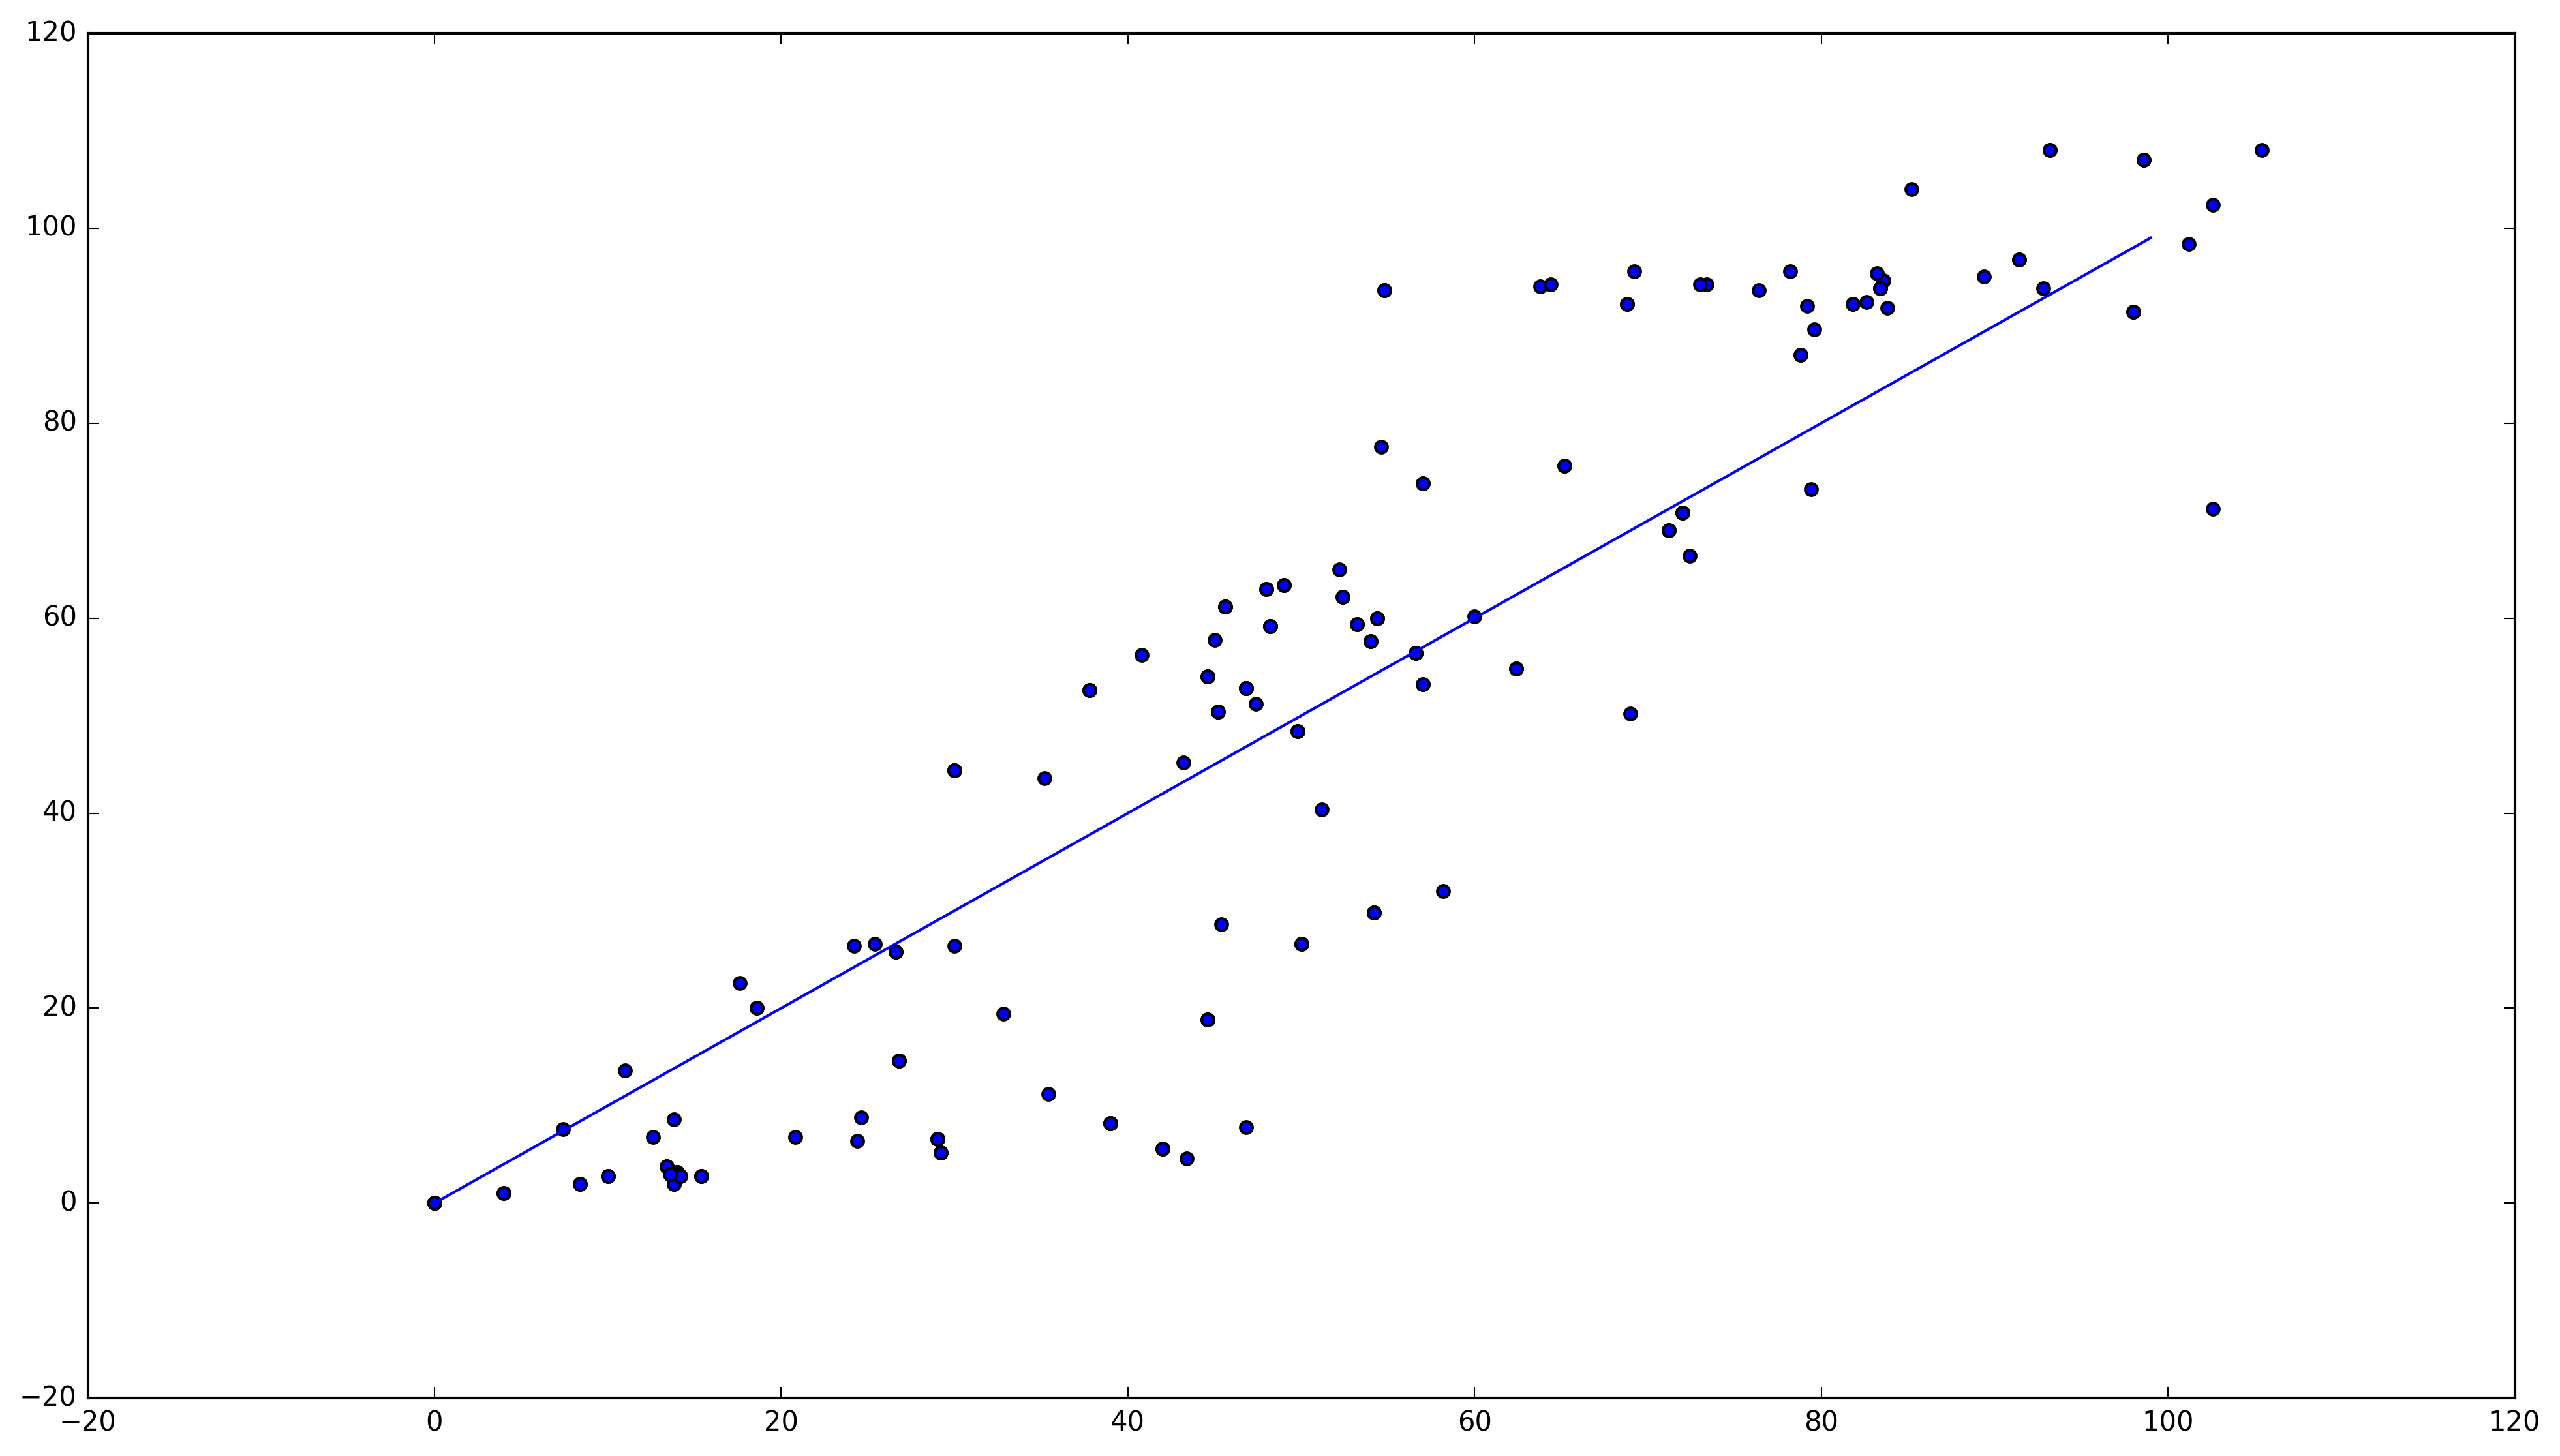

In [20]:
plt.figure(figsize = (16,9), dpi = 300)
plt.scatter(x_e, true_x)
plt.plot(range(100), range(100))
plt.show()

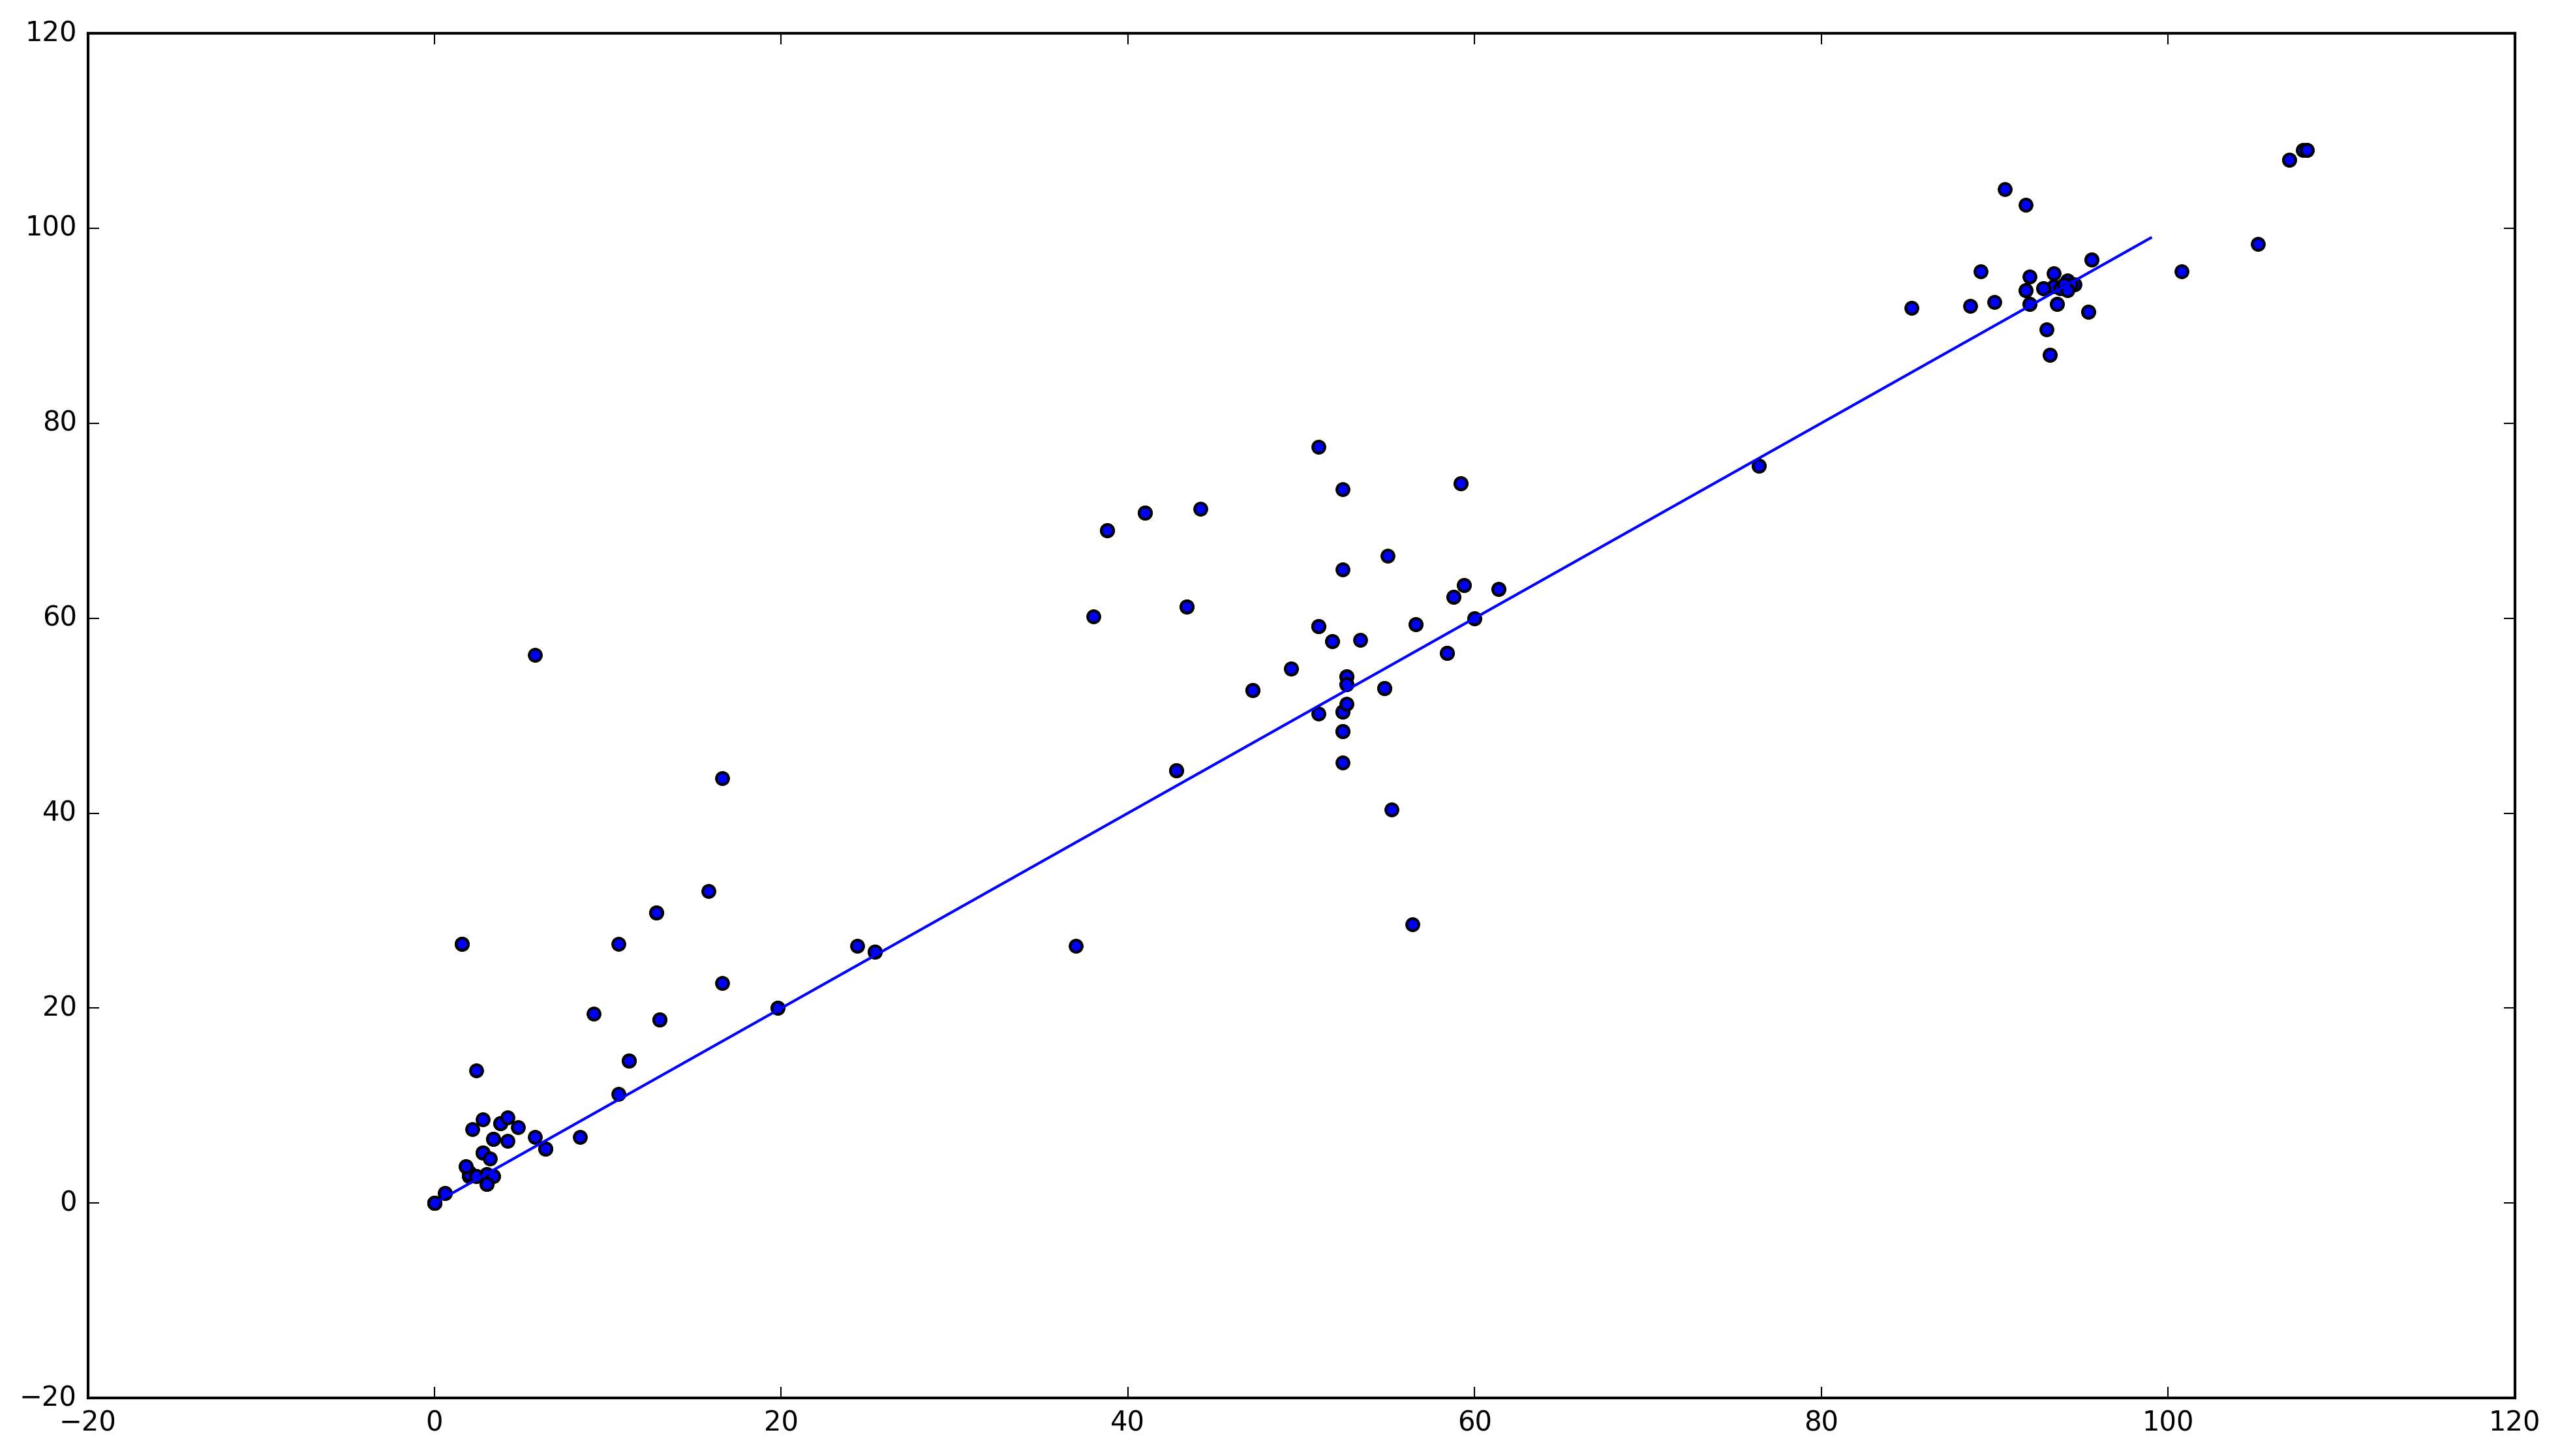

In [21]:
plt.figure(figsize = (16,9), dpi = 300)
plt.scatter(x_ee, true_x)
plt.plot(range(100), range(100))
plt.show()

In [22]:
plt.style.use('seaborn-poster')

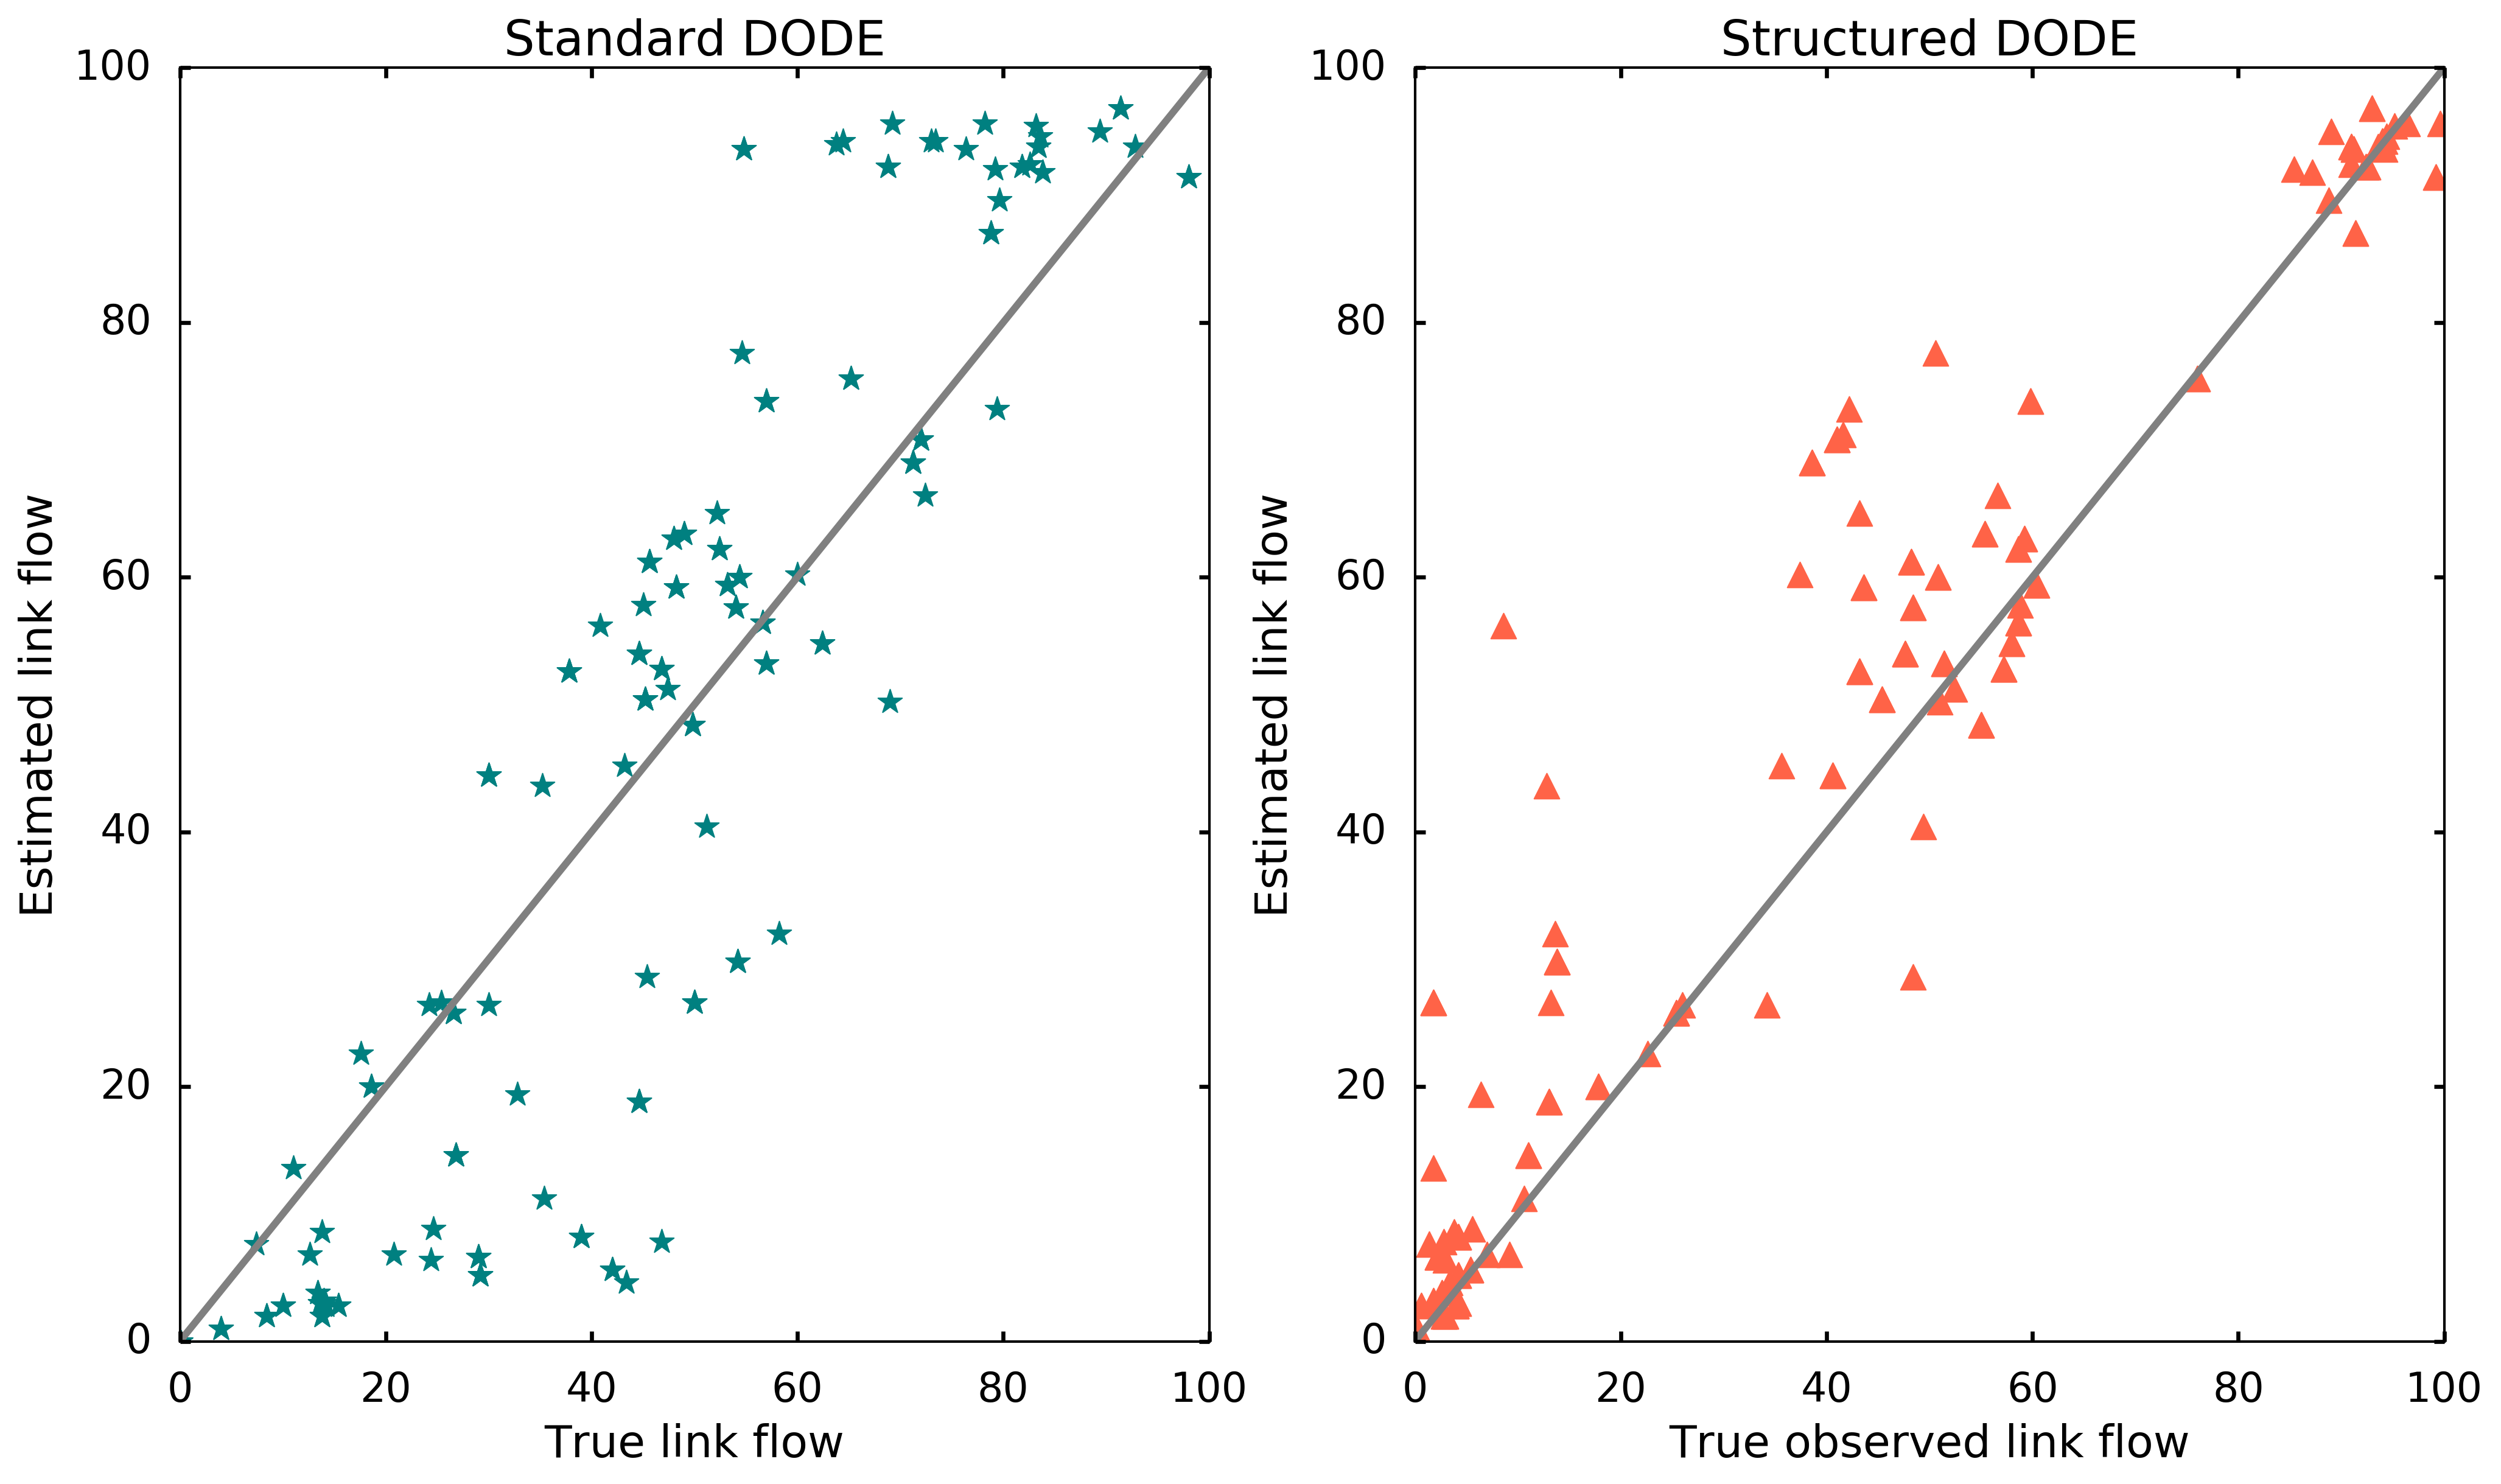

In [37]:
fig, axes = plt.subplots(1,2,  figsize=(16, 9), dpi=300)
# plt.figure(num=None, figsize=(16, 9), dpi=300, facecolor='w', edgecolor='k')
axes[0].scatter(x_e, true_x, label = "Proposed direct solution", color = 'teal', marker = '*', s = 100)
axes[0].plot(range(350), range(350), label = "Convex optimization solution", color = 'gray')
axes[1].scatter(x_ee, true_x, label = "Proposed closed-form method", color = 'tomato', 
                marker = "^", s = 100)
axes[1].plot(range(350), range(350), label = "Convex optimization solution", color = 'gray')
# axes[1].plot(time_list2, gap_rec2, label = "Quadratic solver method", color = 'tomato')
# plt.ylabel("Equilibrium Gap")
# plt.xlabel("Iterations")
# plt.legend()
# plt.xlim([1, 100])
# axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# axes[0].set_title('Path flow rate (vehs/15-min)')
# axes[1].set_title('Path choice probablity')
axes[0].set_ylabel('Estimated link flow')
axes[0].set_xlabel('True link flow')
axes[1].set_ylabel('Estimated link flow')
axes[1].set_xlabel('True observed link flow')
axes[0].set_xlim([0, 100])
axes[0].set_ylim([0, 100])
axes[1].set_xlim([0, 100])
axes[1].set_ylim([0, 100])

axes[0].set_title('Standard DODE')
axes[1].set_title('Structured DODE')

plt.show()

In [38]:
np.linalg.norm(x_ee - true_x)

142.24865552967432

In [39]:
np.linalg.norm(x_e - true_x)

204.20450533717386

In [40]:
from sklearn.metrics import r2_score
from scipy import stats
def r2(predictions, targets):
    y_bar = np.mean(targets)
    # diff = np.minimum(np.abs(predictions - targets), targets)
    diff = predictions - targets
    ss_e = np.sum(diff ** 2)
    ss_t = np.sum((targets) ** 2)
    return 1 - ss_e / ss_t

def rsquared(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value**2

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def rmsn(predictions, targets):
    return np.sqrt(np.sum((predictions - targets) ** 2) * len(predictions)) / np.sum(targets)

In [41]:
rmsn(x_ee, true_x)

0.23316058017321756

In [42]:
rmsn(x_e, true_x)

0.3347127659035623